**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

Integrantes:
*   Candelaria Arpajou: mcarpajou@santafe-conicet.gov.ar
*   Hugo Folonier: hugofolonier@gmail.com
*   Gustavo Jaca: gustavojaca@gmail.com
*   Nicolas Rosales: elnicorosales@gmail.com

**Edición 2022**

---
# **Aprendizaje Profundo**
## **Trabajo Práctico Nº1**

## Librerías

In [ ]:
import gzip
import bz2
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,classification_report
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm.notebook import tqdm, trange

import seaborn

### Uso de GPU en lugar de CPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Clases para Pre-procesado de los Datos

In [ ]:
class MeLiChallengeDataset(Dataset): 
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()
        
        item = {
            "data": self.dataset.iloc[item]["title"],
            "target": self.dataset.iloc[item]["category"]
        }

        if self.transform:
            item = self.transform(item)
        
        return item

In [ ]:
class RawDataProcessor: # Genera el diccionario de lemmas a partir del texto 
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size) #no_below es el mínimo número de documentos donde debe estar el token para pasar el filtro.
                                                                            # no_above es un porcentual, y elimina los tokens que estén en un porcentaje mayor al valor (1 es 100%). Es un valor entre 0 y 1 y estando en 1 no filtra nada... Esta pensado para eliminar los registros más repetidos
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [ ]:
class PadSequences: # Completa con 0 los valores faltantes para obtener tensores de igual longitud
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }


## Ingesta de Datos

### Dataset de Entrenamiento

In [ ]:
raw_dataset_train = pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz',lines = True)  # 4.895.280 filas
#raw_dataset_train = pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz',lines = True) # 1.223.820 filas
#raw_dataset_train = pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz',lines = True) # 63.680 filas
raw_dataset_train.head(3)

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280


In [ ]:
print(f'El dataset de entrenamiento tiene {raw_dataset_train.shape[0]} entradas y {raw_dataset_train.shape[1]} columnas')

El dataset de entrenamiento tiene 4895280 entradas y 10 columnas


In [ ]:
mini_dataset_train = raw_dataset_train[['title','category','data']].copy() #mini DF con las columnas que necesitamos
#mini_dataset_train.head(3)

In [ ]:
# Esto solo agrega dos variables de observación con el largo de la descripción y la cantidad de tokens que tiene el DF inicialmente
mini_dataset_train['title_length'] = mini_dataset_train['title'].apply(lambda x: len(x))
mini_dataset_train['data_length'] = mini_dataset_train['data'].apply(lambda x: len(x))
#mini_dataset_train.sort_values(by='title_length', ascending=False).head(3)
mini_dataset_train.sort_values(by='data_length', ascending=False).head(3)

,title,category,data,title_length,data_length
3454941,Bateria 5200mah Para Sony Vaio Vpc Series Vgp-...,LAPTOP_BATTERIES,"[15, 149, 665, 1851, 16675, 1207, 8811, 1925, ...",120,20
770177,Bateria Para Sony Vaio Vgp-bps13 Vgp-bps13a Vg...,LAPTOP_BATTERIES,"[15, 665, 1851, 8811, 1925, 8811, 8808, 8811, ...",120,20
2567432,Bateria Para Sony Vaio Pcg Vgn-ar Vgn-nr Vgn-s...,LAPTOP_BATTERIES,"[15, 665, 1851, 16444, 1852, 1852, 1852, 1852,...",120,19


### Dataset de Validación

In [ ]:
raw_dataset_val = pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz',lines = True) # 1.223.820 filas
#raw_dataset_val = pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz',lines = True) # 63.680 filas
raw_dataset_val.head(3)

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,unreliable,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS,validation,"[metal, biela, hdi]","[457, 1480, 3450]",88,632,1223820
1,spanish,unreliable,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS,validation,"[repuestos, martillo, rotoprcutor, bosch, gshs...","[3119, 892, 1, 767, 1, 9337]",174,632,1223820
2,spanish,unreliable,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS,validation,"[pesca, caña, pejerrey, colony, brava, fibra, ...","[700, 990, 2057, 3990, 3670, 1737, 1153, 6568]",313,632,1223820


In [ ]:
print(f'El dataset de validación tiene {raw_dataset_val.shape[0]} entradas y {raw_dataset_val.shape[1]} columnas')

El dataset de validación tiene 1223820 entradas y 10 columnas


In [ ]:
mini_dataset_val = raw_dataset_val[['title','category','data']].copy() #mini DF con las columnas que necesitamos
#mini_dataset_val.head(3)

In [ ]:
# Esto solo agrega dos variables de observación con el largo de la descripción y la cantidad de tokens que tiene el DF inicialmente
mini_dataset_val['title_length'] = mini_dataset_val['title'].apply(lambda x: len(x))
mini_dataset_val['data_length'] = mini_dataset_val['data'].apply(lambda x: len(x))
#mini_dataset_val.sort_values(by='title_length', ascending=False).head(3)
mini_dataset_val.sort_values(by='data_length', ascending=False).head(3)

,title,category,data,title_length,data_length
172878,Juego Set Kit Bosch 100 Pzs Mechas Widia Metal...,DRILL_BITS,"[258, 489, 521, 767, 12039, 847, 3563, 457, 16...",119,18
617765,Bateria 6 Celdas Vgp-bps24 Para Sony Vaio Vgp-...,LAPTOP_BATTERIES,"[15, 9917, 8811, 1925, 665, 1851, 8811, 23132,...",120,18
1217764,Campera Honda Hrc Troy Lee Designs Moto Atv Qu...,MOTORCYCLE_JACKETS,"[181, 834, 36204, 14192, 7486, 5119, 1744, 574...",120,18


### Dataset de Test

In [ ]:
raw_dataset_test = pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz',lines = True) # 1.223.820 filas
raw_dataset_test.head(3)

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...,DIAPER_BAGS,test,"[mochilas, maternales, bolsos, bebe, simil, cu...","[5650, 5271, 5268, 915, 2724, 375, 37363]",318,632,63680
1,spanish,reliable,Bolso Maternal/bebe Incluye Cambiador + Correa...,DIAPER_BAGS,test,"[bolso, maternal, bebe, incluye, cambiador, co...","[502, 2742, 915, 3031, 2740, 1840, 4635]",318,632,63680
2,spanish,reliable,Mochila Maternal Land + Gancho Envio Gratis-cc,DIAPER_BAGS,test,"[mochila, maternal, land, gancho, envio, gratis]","[337, 2742, 2741, 3303, 211, 1429]",318,632,63680


In [ ]:
print(f'El dataset de test tiene {raw_dataset_test.shape[0]} entradas y {raw_dataset_test.shape[1]} columnas')

El dataset de test tiene 63680 entradas y 10 columnas


In [ ]:
mini_dataset_test = raw_dataset_test[['title','category','data']].copy() #mini DF con las columnas que necesitamos
#mini_dataset_test.head(3)

In [ ]:
# Esto solo agrega dos variables de observación con el largo de la descripción y la cantidad de tokens que tiene el DF inicialmente
mini_dataset_test['title_length'] = mini_dataset_test['title'].apply(lambda x: len(x))
mini_dataset_test['data_length'] = mini_dataset_test['data'].apply(lambda x: len(x))
#mini_dataset_test.sort_values(by='title_length', ascending=False).head(3)
mini_dataset_test.sort_values(by='data_length', ascending=False).head(3)

,title,category,data,title_length,data_length
4803,Buzo Anti Social Social Club Trap Rap Hip Hop ...,SWEATSHIRTS_AND_HOODIES,"[574, 827, 23435, 23435, 2835, 3294, 12197, 16...",60,12
49244,Jenga Yenga Shenga Jng Top Toys Juego Mesa Tip...,BOARD_GAMES,"[27469, 27471, 1, 5151, 1253, 2851, 258, 236, ...",57,11
10547,Fei Lun Fx176c1 Cámara Drone Fpv Wifi Gps Rtf ...,DRONES,"[48008, 28395, 31581, 85, 3004, 4960, 304, 244...",60,11


### Generamos un Diccionario Único

In [ ]:
df_total = pd.concat([mini_dataset_train, mini_dataset_val, mini_dataset_test], ignore_index=True)
df_total.head(3)

,title,category,data,title_length,data_length
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES,"[50001, 2, 50000, 3]",31,4
1,Neceser Cromado Holográfico,TOILETRY_BAGS,"[6, 4, 5]",28,3
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,"[9, 7, 10, 8]",36,4


In [ ]:
# Es una instancia del RawDataPorcessor para los datos de entrenamiento
pre_process_total = RawDataProcessor(df_total)

In [ ]:
print(f'Largo del Diccionario Completo: {len(pre_process_total.dictionary)}\n') # 15505

Largo del Diccionario Completo: 50002



### Preprocessing

In [ ]:
# Probamos con un diccionario único para todo el dataset
processed_train = MeLiChallengeDataset(mini_dataset_train, transform=pre_process_total) 
processed_val = MeLiChallengeDataset(mini_dataset_val, transform=pre_process_total)
processed_test = MeLiChallengeDataset(mini_dataset_test, transform=pre_process_total)

In [ ]:
EPOCHS = 10
FILTERS_COUNT = 100
FILTERS_LENGTH = [2, 3, 4]

pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))
train_loader = DataLoader(processed_train, batch_size=128, shuffle=True, collate_fn=pad_sequences, drop_last=False)
val_loader = DataLoader(processed_val, batch_size=128, shuffle=True, collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(processed_test, batch_size=128, shuffle=True, collate_fn=pad_sequences, drop_last=False)

In [ ]:
print(iter(train_loader).next()['data'])
print(iter(train_loader).next()['target'])

tensor([[ 593, 7186, 3673,  ...,    0,    0,    0],
        [ 495, 1992,  475,  ...,    0,    0,    0],
        [8801, 1287,   86,  ...,    0,    0,    0],
        ...,
        [9523,  940, 2120,  ...,    0,    0,    0],
        [5887, 8289, 3541,  ...,    0,    0,    0],
        [1344,  164, 2605,  ...,    0,    0,    0]])
tensor([193., 547., 547., 600., 530., 503., 278.,  86., 431., 297.,  65., 416.,
        120., 105., 420., 615., 168., 423., 247.,  37., 346.,  58., 188., 275.,
        226., 102., 365., 524.,  95., 335., 352., 454., 482., 441., 477., 569.,
        266., 577., 605., 187., 419., 537.,  25., 447., 178., 505., 546., 143.,
        137., 587., 406., 605., 443., 119., 244., 306., 445., 618., 195., 372.,
        150., 391., 488.,   3., 318., 481., 333., 631.,  45., 467., 146.,  42.,
        118.,   3., 148.,   1., 500., 617., 296., 548., 516., 397., 477., 192.,
        597., 321., 200., 333., 548.,   2., 265., 422., 523., 101.,  30.,   2.,
        148., 566., 335.,  89., 26

In [ ]:
print(iter(train_loader).next()['data'].shape)
print(iter(train_loader).next()['target'].shape)

torch.Size([128, 11])
torch.Size([128])


## Modelo

In [ ]:
class SuperSimpleConv(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        
        # Inicializamos la matriz de embeddings        
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        
        # Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] = torch.FloatTensor([float(n) for n in vector.split()])
                    
        # Los guardamos en embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix, freeze=freeze_embedings, padding_idx=0)
        
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght) #(in_channels, out_channels, kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 2 ** 10)
        self.output_layer = nn.Linear(2 ** 10, 632)
        self.vector_size = vector_size
    
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = self.output_layer(x)  # Output Layer
        return x

In [ ]:
# Instanciamos el Modelo con el embedding ya pre-entrenado
model = SuperSimpleConv('./data/meli-challenge-2019/SBW-vectors-300-min5.txt.bz2',pre_process_total.dictionary, 300, True)
#model.load_state_dict(torch.load("./data/modelo-conv.pth"))  # Cargar un modelo ya entrenado si es necesario

In [ ]:
# Para uso del GPU
model.to(device)

SuperSimpleConv(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=632, bias=True)
)

In [ ]:
# Modelo de loss y optimizador
loss_function = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # hiperparametros 1
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)  # hiperparametros 2
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)  # hiperparametros 3

## Entrenamiento

In [ ]:
df_datos = pd.DataFrame(columns=['epoch','train_loss','val_loss','val_accuracy'])
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
for epoch in range(EPOCHS):
    
    model.train()
    running_loss = 0.0
    running_loss2 = []
    pbar = tqdm(train_loader)
    
    for i, data in enumerate(pbar, 1):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs = data["data"].to(device)
        labels = data["target"].to(device).to(torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss2.append(loss.item())        

        # print statistics
        running_loss += loss.item()
        if i > 0 and i % 50 == 0:    # print every 50 mini-batches
            pbar.set_description(f"[{epoch + 1}, {i}] loss: {running_loss / 50:.4g}")
            running_loss = 0.0
    history['train_loss'].append((epoch, sum(running_loss2) / len(running_loss2)))

    # At the end of the epoch, evaluate model on validation
    model.eval();  # Activate evaluation mode
    running_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        p2bar = tqdm(val_loader)
        for i, data in enumerate(p2bar, 1):
            inputs = data["data"].to(device)
            labels = data["target"]
            outputs = model(inputs)
            running_loss += loss_function(outputs, labels.to(device).to(torch.long)).item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    history['val_accuracy'].append(balanced_accuracy_score(y_true, y_pred))
    history['val_loss'].append((epoch, running_loss / i))
    df_datos=df_datos.append({'epoch' : epoch+1 , 
                              'train_loss' : sum(running_loss2) / len(running_loss2),
                              'val_loss' : running_loss / i,
                              'val_accuracy' : balanced_accuracy_score(y_true, y_pred)} , ignore_index=True)
    df_datos.to_csv('./data/datos_finales_conv-hip3.csv')
    # Guardamos el modelo
    torch.save(model.state_dict(), "./data/modelo-conv-hip3.pth")

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/tmp/ipykernel_3119801/2683160660.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_datos=df_datos.append({'epoch' : epoch+1 ,


In [ ]:
# history['train_loss']

In [ ]:
# history['val_loss']

In [ ]:
# history['val_accuracy']

In [ ]:
#data = []
#for epoch, (train_loss, val_loss) in enumerate(zip(
#        history['train_loss'], history['val_loss'])):
#    data.append((epoch, 'train', train_loss[1]))
#    data.append((epoch, 'val', val_loss[1]))
#data = pd.DataFrame(data=data, columns=['epoch', 'dataset', 'loss'])
#seaborn.pointplot(
#    data=data, x='epoch', y='loss', hue='dataset'
#)

## Validación

In [ ]:
model.eval()

y_true = []
y_pred = []

p2bar = tqdm(test_loader)

for batch in (p2bar):
        
    inputs = batch["data"].to(device)
    labels = batch["target"]
        
    predict = model(inputs)
    _, predict = torch.max(predict.data, 1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predict.cpu().numpy())
    
y_true = np.array(y_true, dtype=int)

  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
print(f'Largo del vector target: {len(y_true)}\nLargo del vector Prediction: {len(y_pred)}')

Largo del vector target: 63680
Largo del vector Prediction: 63680


In [ ]:
print(classification_report(y_true, y_pred, labels=np.unique(y_pred)))

# Hiperparametros 1:  lr=0.01 momentum = 0.9
#     accuracy                           0.85     63680
#    macro avg       0.86      0.85      0.85     63680
# weighted avg       0.86      0.85      0.85     63680

# Hiperparametros 2:  lr=0.01 momentum = 0.5
#     accuracy                           0.83     63680
#    macro avg       0.85      0.83      0.83     63680
# weighted avg       0.85      0.83      0.83     63680

# Hiperparametros 3:  lr=0.05 momentum = 0.9
#     accuracy                           0.78     63680
#    macro avg       0.81      0.78      0.78     63680
# weighted avg       0.81      0.78      0.78     63680

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        98
           1       0.86      0.93      0.89       100
           2       0.69      0.76      0.72        98
           3       0.34      0.62      0.44       102
           4       0.85      0.93      0.89        99
           5       0.89      0.72      0.80        98
           6       0.99      0.94      0.96       100
           7       0.88      0.95      0.91       100
           8       0.66      0.88      0.76       101
           9       0.83      0.92      0.87       104
          10       0.59      0.81      0.68        98
          11       0.66      0.82      0.73       101
          12       0.82      0.62      0.70       102
          13       0.99      0.70      0.82       107
          14       0.78      0.74      0.76        99
          15       0.53      0.69      0.60       100
          16       0.84      0.67      0.75       104
          17       0.99    

## Bloques para generar gráficos

In [2]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

df_MLP1=pd.read_csv('datos_finales_MLP-hip1.csv')
df_conv1=pd.read_csv('datos_finales_conv-hip1.csv')
df_MLP2=pd.read_csv('datos_finales_MLP-hip2.csv')
df_conv2=pd.read_csv('datos_finales_conv-hip2.csv')
df_MLP3=pd.read_csv('datos_finales_MLP-hip3.csv')
df_conv3=pd.read_csv('datos_finales_conv-hip3.csv')

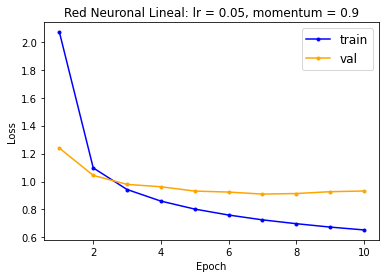

In [7]:
plt.plot(df_MLP3['epoch'], df_MLP3['train_loss'], marker='.',color='blue', label='train')
plt.plot(df_MLP3['epoch'], df_MLP3['val_loss'], marker='.',color='orange', label='val')
plt.legend(loc='best', facecolor='w', fontsize=12)
plt.title('Red Neuronal Lineal: lr = 0.05, momentum = 0.9', fontdict=None, loc='center', pad=None)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("MLP-loss-hip3.jpg")
plt.show()


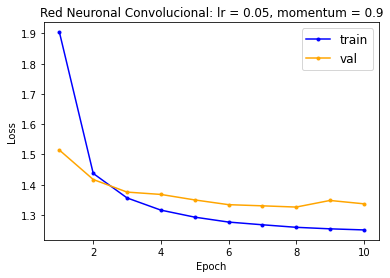

In [11]:
plt.plot(df_conv3['epoch'], df_conv3['train_loss'], marker='.',color='blue', label='train')
plt.plot(df_conv3['epoch'], df_conv3['val_loss'], marker='.',color='orange', label='val')
plt.legend(loc='best', facecolor='w', fontsize=12)
plt.title('Red Neuronal Convolucional: lr = 0.05, momentum = 0.9', fontdict=None, loc='center', pad=None)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("conv-loss-hip3.jpg")
plt.show()

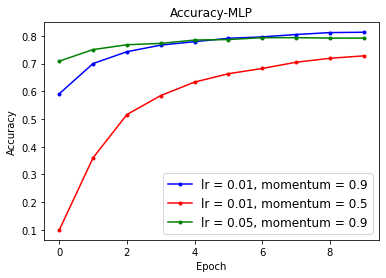

In [17]:
plt.plot(df_MLP1['val_accuracy'], marker='.',color='blue', label='lr = 0.01, momentum = 0.9')
plt.plot(df_MLP2['val_accuracy'], marker='.',color='red', label='lr = 0.01, momentum = 0.5')
plt.plot(df_MLP3['val_accuracy'], marker='.',color='green', label='lr = 0.05, momentum = 0.9')
plt.legend(loc='best', facecolor='w', fontsize=12)
plt.title('Accuracy-MLP', fontdict=None, loc='center', pad=None)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig("accuracyMLP.jpg")
plt.show()

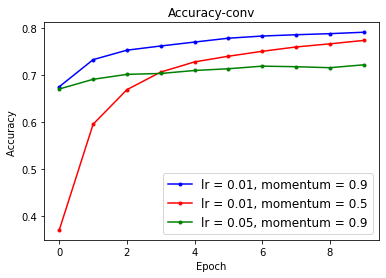

In [18]:
plt.plot(df_conv1['val_accuracy'], marker='.',color='blue', label='lr = 0.01, momentum = 0.9')
plt.plot(df_conv2['val_accuracy'], marker='.',color='red', label='lr = 0.01, momentum = 0.5')
plt.plot(df_conv3['val_accuracy'], marker='.',color='green', label='lr = 0.05, momentum = 0.9')
plt.legend(loc='best', facecolor='w', fontsize=12)
plt.title('Accuracy-conv', fontdict=None, loc='center', pad=None)
plt.xlabel('Epoch')
plt.ylabel('Accuracy ')
plt.savefig("accuracyconv.jpg")
plt.show()